# Autoregressive RNN with continuous input
- This model is autoregressive, which means that the prediction of the last time step is the input of the current time step. This way the model can predict a varying number of steps into the future without retraining
- Some features, like time and weather, are fed into the model from outside even during prediction phase so the model does not have to predict those by itself

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display

sns.set_theme()

### Import data

In [2]:
df = pd.read_pickle("..\data\data_prepared.pkl")
df.head()

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2020-01-01 00:00:00+00:00,6989.50,0.0,-7.670342e-12,1.000000,-2.150345e-03,0.999998,-60.949049,0.0
2020-01-01 01:00:00+00:00,7371.25,0.0,2.588190e-01,0.965926,-1.433564e-03,0.999999,-56.073363,0.0
2020-01-01 02:00:00+00:00,7447.75,0.0,5.000000e-01,0.866025,-7.167823e-04,1.000000,-48.553549,0.0
2020-01-01 03:00:00+00:00,7699.25,0.0,7.071068e-01,0.707107,1.964387e-15,1.000000,-39.725411,0.0
2020-01-01 04:00:00+00:00,7703.00,0.0,8.660254e-01,0.500000,7.167823e-04,1.000000,-30.389395,0.0


### Split the data
- 70% training
- 20% validation
- 10% test

In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

### Normalize the data

In [4]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

In [5]:
len(df_train.columns)

8

### Data Windowing
#### 1. Indexes and offsets

- Windows Generator that can create multiple inputs, one for the inputs that are only known in the past (power production) and one for inputs that are also known in the future (time and weather)

In [6]:
class WindowGenerator():
    def __init__(self, past_width, future_width,
                 label_columns, precise_columns=None, forecast_columns=None,
                 train_df=df_train, val_df=df_val, test_df=df_test):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Check if length of provided features match with data frame
        num_columns = 0
        num_columns += len(label_columns)
        if precise_columns is not None:
            num_columns += len(precise_columns)
        if forecast_columns is not None:
            num_columns += len(forecast_columns)
        assert num_columns == len(df_train.columns), \
            "Length of provided label, precise, and forecast features do not match data frame"

        # Work out the column indices
        self.columns_indices = {name: i for i, name in
                                enumerate(train_df.columns)}
        self.label_columns = label_columns
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
        self.precise_columns = precise_columns
        if precise_columns is not None:
            self.precise_columns_indices = {name: i for i, name in
                                            enumerate(precise_columns)}
        self.forecast_columns = forecast_columns
        if forecast_columns is not None:
            self.forecast_columns_indices = {name: i for i, name in
                                             enumerate(forecast_columns)}

        # Work out the window parameters.
        self.past_width = past_width
        self.future_width = future_width

        self.total_window_size = past_width + future_width

        self.past_slice = slice(0, past_width)
        self.past_indices = np.arange(self.total_window_size)[self.past_slice]

        self.future_slice = slice(self.past_width, None)
        self.future_indices = np.arange(self.total_window_size)[
            self.future_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size:       {self.total_window_size}',
            f'Past indices:            {self.past_indices}',
            f'Future indices:          {self.future_indices}',
            f'Label column name(s):    {self.label_columns}',
            f'Precise column name(s):  {self.precise_columns}',
            f'Forecast column name(s): {self.forecast_columns}'])


#### 2. Split

In [7]:
def split_window(self, features):
    # Past: All inputs are known
    inputs_past = features[:, self.past_slice, :]

    # Future: Only precise and forecast inputs are known
    if self.precise_columns is None:
        self.precise_columns = []
    if self.forecast_columns is None:
        self.forecast_columns = []
    self.inputs_future_columns = self.precise_columns + self.forecast_columns

    inputs_future = tf.stack(
        [features[:, self.future_slice, self.columns_indices[name]]
            for name in self.inputs_future_columns],
        axis=-1)

    labels = tf.stack(
        [features[:, self.future_slice, self.columns_indices[name]]
            for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs_past.set_shape([None, self.past_width, None])
    inputs_future.set_shape([None, self.future_width, None])
    labels.set_shape([None, self.future_width, None])

    # Return inputs and labels
    # The past and future input tuple will be unpacked in the model.call() method
    return (inputs_past, inputs_future), labels


WindowGenerator.split_window = split_window


Creating a window:

In [8]:
# Choose which features are only known for the past. These features will be predicted.
prediction_features = ['prod_wind', 'prod_solar']
num_predictions = len(prediction_features)

# Choose which features are precisely known to the model at all time steps
precise_features = ['day_sin', 'day_cos', 'year_sin',
                    'year_cos', 'solar_el', 'solar_el_clip']

# Choose which features are only imprecisely known to the model at future time steps
# NOISE NOT YET IMPLEMENTED
forecast_features = None

PAST_STEPS = 24
PREDICTION_STEPS = 24

multi_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    past_width=PAST_STEPS, future_width=PREDICTION_STEPS,
    label_columns=prediction_features,
    precise_columns=precise_features,
    forecast_columns=forecast_features
)

multi_window


Total window size:       48
Past indices:            [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Future indices:          [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s):    ['prod_wind', 'prod_solar']
Precise column name(s):  ['day_sin', 'day_cos', 'year_sin', 'year_cos', 'solar_el', 'solar_el_clip']
Forecast column name(s): None

#### 3. Plot

In [9]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
  inputs, labels = self.example
  (inputs_past, inputs_future) = inputs
  plt.figure(figsize=(12, 8))
  plot_col_index = self.columns_indices[plot_col]
  max_n = min(max_subplots, len(inputs_past))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.past_indices, inputs_past[n, :, plot_col_index],
             label='Inputs', marker='.')

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.future_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.future_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xticks(np.arange(min(self.future_indices), max(self.future_indices)+1, 6))
  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

#### 4. Create `tf.data.Datasets`

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives access to the tf.data.Dataset objects, to easily iterate over the data.

The `Dataset.element_spec` property tells the structure, data types, and shapes of the dataset elements.

In [12]:
multi_window.train.element_spec

((TensorSpec(shape=(None, 24, 8), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 24, 6), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [13]:
for (example_inputs_past, example_inputs_future), example_labels in multi_window.train.take(1):
  print(f'Inputs past shape (batch, time, features): {example_inputs_past.shape}')
  print(f'Inputs fut. shape (batch, time, features): {example_inputs_future.shape}')
  print(f'Labels shape      (batch, time, features): {example_labels.shape}')

Inputs past shape (batch, time, features): (32, 24, 8)
Inputs fut. shape (batch, time, features): (32, 24, 6)
Labels shape      (batch, time, features): (32, 24, 2)


Plot an example window:

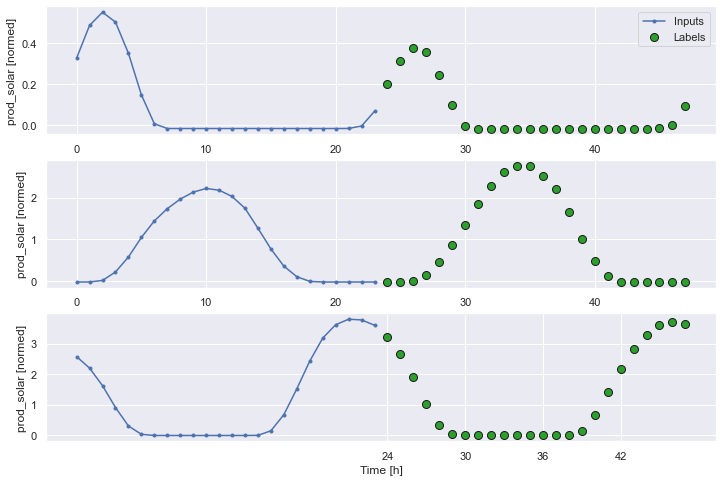

In [14]:
multi_window.plot(plot_col="prod_solar")
# multi_window.plot(plot_col="prod_wind")

## Autoregressive LSTM
The model predicts individual time steps that are fed back into itself, so that the model can produce output with a varying length.
This is implemented in the custom model class `FeedBack`.

In [15]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_predictions)

In [16]:
arlstm_model = FeedBack(units=32, out_steps=PREDICTION_STEPS)

#### Model warmup
The warmup method initializes the model's internal state based on the full input from the past (power data, time and weather)

In [17]:
def warmup(self, inputs_past):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs_past)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [18]:
prediction, state = arlstm_model.warmup(multi_window.example[0][0])
prediction.shape

TensorShape([32, 2])

#### Model call
A custom call is used to feed the model the full input from the past during warmup and then only the time and weather forecast during the prediction phase, where the model takes the prediction from the last time step to substitute the missing input.

In [19]:
def call(self, inputs, training=None):
    # unpack the past and future inputs
    inputs_past, inputs_future = inputs
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Past phase: Initialize the LSTM state
    prediction, state = self.warmup(inputs_past)
    # Insert the first prediction.
    predictions.append(prediction)

    # Future phase: Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Select the known input at the current time step
        input = inputs_future[:,n-1,:]
        # Use the last prediction as unknown input and combine it with the known input
        # x.shape => (batch, features)
        x = tf.concat([prediction, input], axis=1)
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


FeedBack.call = call


Run on example input:

In [20]:
print('Output shape (batch, time, features): ', arlstm_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 2)


In [21]:
arlstm_model.call(multi_window.example[0])
arlstm_model.summary()

Model: "feed_back"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell (LSTMCell)        multiple                  5248      
                                                                 
 rnn (RNN)                   multiple                  5248      
                                                                 
 dense (Dense)               multiple                  66        
                                                                 
Total params: 5,314
Trainable params: 5,314
Non-trainable params: 0
_________________________________________________________________


#### Training procedure

In [22]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      verbose=1)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

val_performance = {}
test_performance = {}
history = {}


In [23]:
history['ARLSTM'] = compile_and_fit(arlstm_model, multi_window)
# IPython.display.clear_output()

val_performance['ARLSTM'] = arlstm_model.evaluate(multi_window.val)
test_performance['ARLSTM'] = arlstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 5s 7ms/step - loss: 0.2166 - mean_absolute_error: 0.3283 - val_loss: 0.1228 - val_mean_absolute_error: 0.2465
Epoch 2/50
383/383 [==============================] - 3s 7ms/step - loss: 0.1377 - mean_absolute_error: 0.2530 - val_loss: 0.1081 - val_mean_absolute_error: 0.2190
Epoch 3/50
383/383 [==============================] - 2s 6ms/step - loss: 0.1305 - mean_absolute_error: 0.2429 - val_loss: 0.1061 - val_mean_absolute_error: 0.2205
Epoch 4/50
383/383 [==============================] - 3s 7ms/step - loss: 0.1270 - mean_absolute_error: 0.2374 - val_loss: 0.1055 - val_mean_absolute_error: 0.2125
Epoch 5/50
383/383 [==============================] - 2s 6ms/step - loss: 0.1238 - mean_absolute_error: 0.2330 - val_loss: 0.1201 - val_mean_absolute_error: 0.2350
Epoch 6/50
383/383 [==============================] - 2s 6ms/step - loss: 0.1206 - mean_absolute_error: 0.2293 - val_loss: 0.1017 - val_mean_absolute_error: 0.2093
Epoch 7/50
383/3

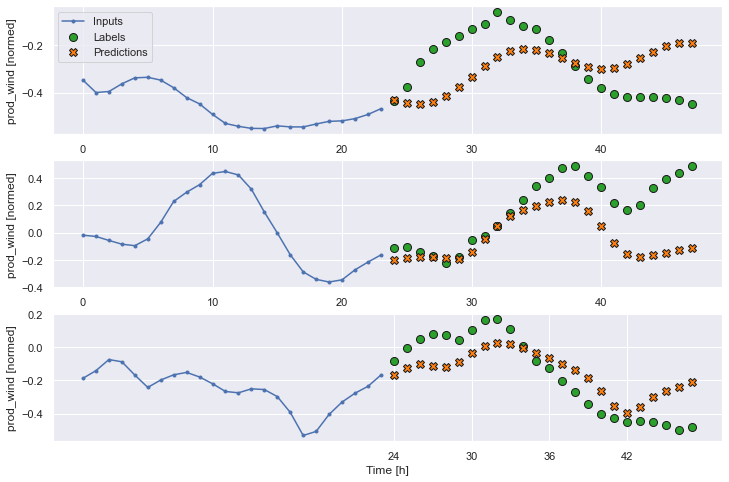

In [24]:
multi_window.plot(arlstm_model, plot_col="prod_wind")

#### Plot training loss and score

In [25]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    # plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')

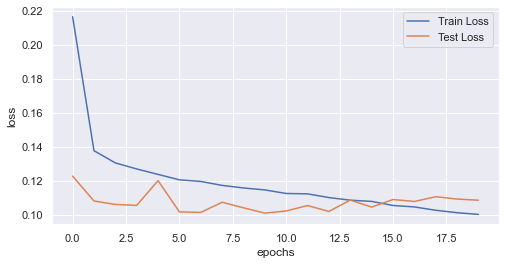

In [28]:
model_loss(history['ARLSTM'])

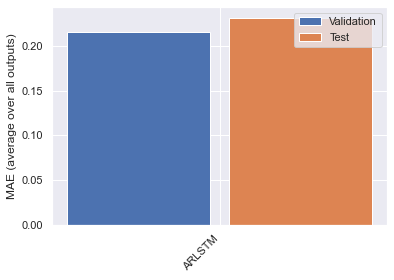

In [29]:
x = np.arange(len(test_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = arlstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=test_performance.keys(),
           rotation=45, ha='right')
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name+":":17s} {value[1]:0.4f}')